## Clothing Review Rating Prediction  

Given *reviews of women's clothing*,predicting whether the rating associated with the review will be **Recomended** or not.

We will use a TensorFlow/Keras recurrent neural network to make our predictions.

## Import dataset & library

In [2]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download nicapotato/womens-ecommerce-clothing-reviews

! unzip womens-ecommerce-clothing-reviews.zip


mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 120MB/s]
Archive:  womens-ecommerce-clothing-reviews.zip
  inflating: Womens Clothing E-Commerce Reviews.csv  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

In [4]:
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

In [8]:
data

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


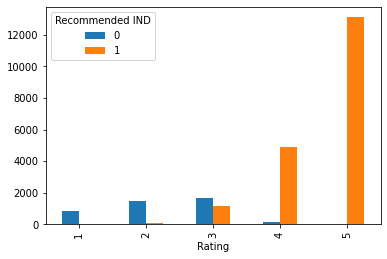

In [6]:
data.groupby('Rating')['Recommended IND'].value_counts().unstack().plot.bar()

# Preprocessing

In [7]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop rows with missing reviews
    missing_review_rows = df[df['Review Text'].isna()].index
    df = df.drop(missing_review_rows, axis=0).reset_index(drop=True)
    
    
    # Use only the review and rating column
    y = df['Rating']
    X = df['Review Text']
    
    
    # Make binary target with rating more than 4 for as recommended
    y = y.apply(lambda x: 1 if x >= 4 else 0)
    
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=40)
    
    
    # Learn the vocabulary
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    
    
    # Find the size of the vocabulary
    vocab_length = len(tokenizer.word_index) + 1
    print("Vocab length:", vocab_length)
    
    
    # Convert review texts into sequences of integers
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    
    # Find the maximum sequence length
    max_seq_length = np.max(list(map(lambda x: len(x), X_train)))
    print("Maximum sequence length:", max_seq_length)
    
    
    # Pad the sequences to by uniform length
    X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post')
    
    
    return X_train, X_test, y_train, y_test, vocab_length, max_seq_length

In [8]:
X_train, X_test, y_train, y_test, VOCAB_LENGTH, MAX_SEQ_LENGTH = preprocess_inputs(data)

Vocab length: 12764
Maximum sequence length: 116


In [9]:
X_train.shape

(15848, 116)

In [10]:
X_test.shape

(6793, 116)

# Model training

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 116)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 116, 128)          1633792   
                                                                 
 gru_1 (GRU)                 (None, 256)               296448    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,930,497
Trainable params: 1,930,497
Non-trainable params: 0
_________________________________________________________________
None


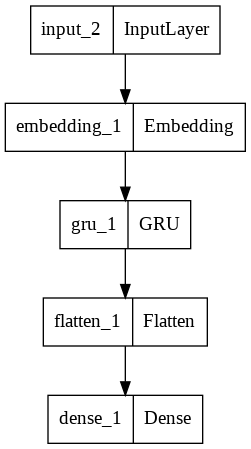

In [12]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

word_embedding = tf.keras.layers.Embedding(     #  Applied Embeded method layers
    input_dim=VOCAB_LENGTH,
    output_dim=128,
    input_length=MAX_SEQ_LENGTH
)(inputs) 


x = tf.keras.layers.GRU(256, return_sequences=False, activation='tanh')(word_embedding)  # GRU layers
x = tf.keras.layers.Flatten()(x)  # Flatten dimenson

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
397/397 [==============================] - 21s 34ms/step - loss: 0.5414 - accuracy: 0.7698 - val_loss: 0.5309 - val_accuracy: 0.7770
Epoch 2/100
397/397 [==============================] - 13s 32ms/step - loss: 0.5406 - accuracy: 0.7711 - val_loss: 0.5308 - val_accuracy: 0.7770
Epoch 3/100
397/397 [==============================] - 13s 32ms/step - loss: 0.5173 - accuracy: 0.7758 - val_loss: 0.3814 - val_accuracy: 0.8363
Epoch 4/100
397/397 [==============================] - 13s 32ms/step - loss: 0.3608 - accuracy: 0.8480 - val_loss: 0.2945 - val_accuracy: 0.8707
Epoch 5/100
397/397 [==============================] - 13s 33ms/step - loss: 0.2417 - accuracy: 0.9057 - val_loss: 0.2936 - val_accuracy: 0.8808
Epoch 6/100
397/397 [==============================] - 13s 32ms/step - loss: 0.1697 - accuracy: 0.9363 - val_loss: 0.2838 - val_accuracy: 0.8804
Epoch 7/100
397/397 [==============================] - 13s 32ms/step - loss: 0.1182 - accuracy: 0.9576 - val_loss: 0.3409 - val_ac

# Results

In [14]:
model.evaluate(X_test, y_test)

213/213 [==============================] - 3s 14ms/step - loss: 0.2958 - accuracy: 0.8735


[0.295825719833374, 0.873546302318573]

In [15]:
def get_pred(test, threshold = 0.5):   # define function evaluate metric with threshold
  pred = np.squeeze(model.predict(test))
  pred = list(map(lambda x: 1 if x > threshold else 0, pred))
  metrics = confusion_matrix(y_test, pred)

  report = classification_report(y_test, pred)

  plt.figure(figsize = (8,8))
  sns.heatmap(metrics,annot=True, fmt='', cmap='Blues', cbar = False)
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.xticks(ticks = [0.5,1.5], labels = [0,1])
  plt.yticks(ticks = [0.5,1.5], labels = [0,1])
  plt.show()

  print('*********************** Classification Report : \n\n', report)

  return pred


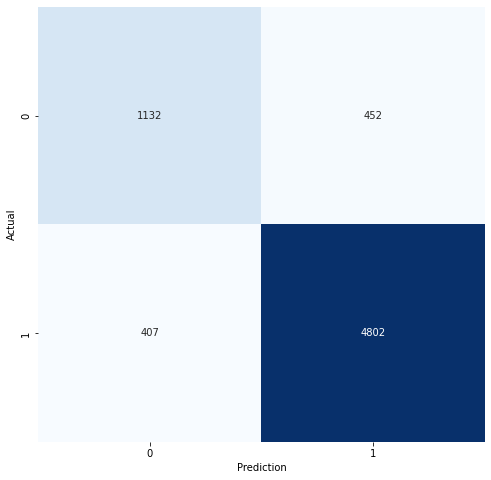

*********************** Classification Report : 

               precision    recall  f1-score   support

           0       0.74      0.71      0.72      1584
           1       0.91      0.92      0.92      5209

    accuracy                           0.87      6793
   macro avg       0.82      0.82      0.82      6793
weighted avg       0.87      0.87      0.87      6793



In [16]:
pred = get_pred(X_test)

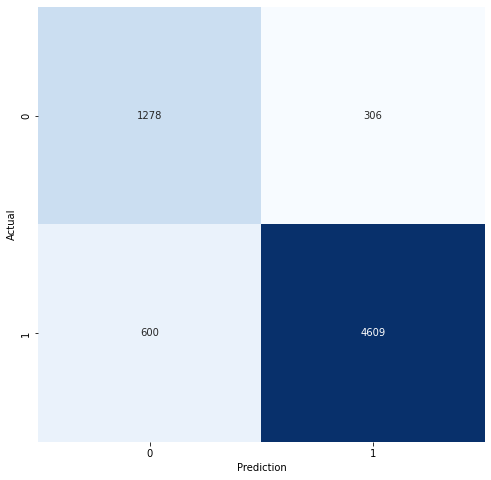

*********************** Classification Report : 

               precision    recall  f1-score   support

           0       0.68      0.81      0.74      1584
           1       0.94      0.88      0.91      5209

    accuracy                           0.87      6793
   macro avg       0.81      0.85      0.82      6793
weighted avg       0.88      0.87      0.87      6793



In [17]:
pred = get_pred(X_test, threshold = 0.7)  #  increase threshold to see other result